# Structural Analysis of Protein Ensembles

This notebook does the following:
- Creates a protein structural ensemble from the PDB structures prepared in [this notebook](../../1_Download_and_prepare_protein_ensembles/4_Prepare_proteins_using_pdb4amber.ipynb). The file is saved into `.dcd` and `.pdb` format files. 
    - Structures are aligned using the $C \alpha$ atoms of the residues comprising the protein's pocket.
- The `.pdb` file is used as input for `POVME` to compute the volume and the shape of the protein's pocket.
- Pair-wise RMSD is computed among all protein conformations.
- Classical Multidimensional Scaling Analysis (cMDS) is performed using the RMSD matrix as input.

In [2]:
import pandas as pd
import numpy as np
import pytraj as pyt
import nglview as nv
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from prody import *
import sys
sys.path.insert(0, '../..')
from helper_modules.get_cocristalized_ligands \
     import get_pocket_ligand, PocketResidues
sns.set(style='ticks', font_scale = 1.2)

## Protein information dataframe

In [3]:
prot_name = 'hsp90'
df_prot_file = f'../1_Download_and_prepare_protein_ensembles/TABLA_MTDATA_HSP90_298_crys_LIGS_INFO.json'
df_prot = pd.read_json(df_prot_file)
df_prot.head()

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
1byq,in vivo function of hsp90 is dependent on atp ...,1998-10-28,1,A,1.50,1.0,29.098,2,"[10, 509]","[[1, 10], [224, 732]]",2,"[ADP, MG]",ADP,412.082022
1osf,crystal structure and molecular modeling of 17...,2003-05-27,1,A,1.75,1.0,29.372,2,"[8, 509]","[[1, 8], [224, 732]]",3,"[KOS, ACY, MPD]",KOS,568.364400
1uy6,structure-activity relationships in purine-bas...,2004-07-01,1,A,1.90,1.0,28.279,2,"[16, 509]","[[1, 16], [224, 732]]",1,[PU3],PU3,346.235000
1uy7,structure-activity relationships in purine-bas...,2004-07-01,1,A,1.90,1.0,28.415,2,"[15, 509]","[[1, 15], [224, 732]]",1,[PU4],PU4,290.214800
1uy8,structure-activity relationships in purine-bas...,2004-07-01,1,A,1.98,1.0,28.279,2,"[16, 509]","[[1, 16], [224, 732]]",1,[PU5],PU5,290.214800


In [4]:
df_prot.shape

(298, 14)

### Only for the HSP90 protein
From the 298 retrieved structures, 2 conformations were not modeled:

In [5]:
path_to_prepared = '../1_Download_and_prepare_protein_ensembles/pdb_structures/pdb_prepared/'
pdbids_list = sorted(glob(f'{path_to_prepared}/*'))
pdbids_list = [i.split('/')[-1].split('_')[0] for i in pdbids_list]
# Update selection keeping only those ids which files were modeled and prepared
df_prot = df_prot[df_prot.index.isin(pdbids_list)]
# Save the dataframe
n_confs = df_prot.shape[0]
df_prot_file = f'../1_Download_and_prepare_protein_ensembles/TABLA_MTDATA_HSP90_{n_confs}_crys_LIGS_INFO.json'
df_prot.to_json(df_prot_file)
df_prot.shape

(296, 14)

## Protein structural ensemble

In [6]:
%run ../../helper_modules/protein_subsequences.py

In [7]:
# Create a trajectory file using the protein ensemble
path_to_pdb_files = '../1_Download_and_prepare_protein_ensembles/pdb_structures/pdb_prepared/*'

# Load all protein structures to a single trajectory
crys_traj = pyt.io.iterload(filename = path_to_pdb_files)

In [8]:
print(f' Number of conformations: {crys_traj.n_frames}\n',
      f'Number of atoms per frame: {crys_traj.n_atoms}.')

 Number of conformations: 296
 Number of atoms per frame: 3273.


In [9]:
view = nv.show_pytraj(crys_traj)
view.add_representation('licorice')
view

NGLWidget(max_frame=295)

### Save protein Ensemble as PDB trajectory

- **Alingment using Pocket subsequence**: PDB format as was used to compute Volumne using POVME3, check folder `./POVME_results`

In [10]:
# Use a reference structure to visualize the pocket residues
prot_name = 'hsp90'
ref_struc_id    = '1byq'
ref_ligand_name = 'ADP'

In [11]:
# Use a reference structure to visualize the pocket residues
pkt_info = PocketResidues(ref_struc_id, ref_ligand_name)
pocket_residues_str = pkt_info.get_pocket_residues_as_list().split(' ')

# Merge the values
pocket_residues_str = list(set(pocket_residues_str))
pocket_residues_str = ','.join(pocket_residues_str)

print('Indices of pocket redsidues:', pocket_residues_str)

Indices of pocket redsidues: 56,107,48,52,185,91,150,50,51,96,183,133,134,49,53,186,58,152,112,93,102,55,132,184,137,97,95,98,136,54,138,47,139,131,106,135


In [12]:
pkt_str_mask = f":{pocket_residues_str}&(@CA)"
pocket_alg = pyt.align(crys_traj, mask = pkt_str_mask)
# Save the traj: This traj was used to compute POVME, check folder ./POVME_results
pyt.write_traj(f'./PDB_{crys_traj.n_frames}_{prot_name}_POCKET_ALL.pdb', 
               pocket_alg, 
               options = 'model',
               overwrite = True)

# Save the traj as dcd file to upload to github
pyt.write_traj(f'./PDB_{crys_traj.n_frames}_{prot_name}_POCKET_ALL.dcd', 
               pocket_alg,
               overwrite = True)

### Compute the center of mass of the pocket using its residues

In [13]:
mask = f":{pocket_residues_str.replace(' ', ',')}"

center_geo = pyt.center_of_geometry(traj=pocket_alg, 
                                    mask=mask, dtype='ndarray', 
                                    frame_indices=None)

center_mass = pyt.center_of_mass(traj=pocket_alg, 
                                    mask=mask, dtype='ndarray', 
                                    frame_indices=None)

print('Center of geometry (mean):', 
      np.round(center_geo.mean(axis = 0)))
print('Center of mass (mean):', 
      np.round(center_mass.mean(axis = 0)))

Center of geometry (mean): [-0. 12. 25.]
Center of mass (mean): [-1. 12. 25.]


In [14]:
view = nv.show_pytraj(pocket_alg)
center = np.round(center_mass.mean(axis = 0), 0).tolist()
center_2 = [2, 9, 24]
view.add_representation('licorice', selection = ':2,4')
view.shape.add_sphere(center_2, [0,0,3,0.2], 12)
view.update_representation(component=1, repr_index = 0, opacity = 0.5)
view

NGLWidget(max_frame=295)

In [15]:
view = pkt_info.visualize_pocket()
view

NGLWidget()

- **Alingment using Pocket subsequence**: PDB format as was used to compute Volumne using POVME3, check folder `./POVME_results`

In [16]:
print(F'PDBID used as reference structure: {ref_struc_id}')
# Use a reference structure to identify the secondary structure residues
header      = parsePDB(ref_struc_id, header=True, model=0)
structure   = parsePDB(ref_struc_id, folder = './')
sec_sctr    = assignSecstr(header, structure.select('protein')).getSecstrs()
sec_sctr_HE = structure.select(F'secondary H E and calpha').getResnums()

sec_sctr_res_list = sec_sctr_HE.tolist()
sec_sctr_res_str = ','.join(map(str, sec_sctr_res_list))
print(F'{len(sec_sctr_res_list)} residues belong \
to the secondary structure of the {prot_name.upper()} protein.')

PDBID used as reference structure: 1byq
92 residues belong to the secondary structure of the HSP90 protein.


In [17]:
# Perform the alignment
sec_str_mask = f':{sec_sctr_res_str}&(@CA)'
sec_str_alg = pyt.align(crys_traj, mask = sec_str_mask)

# Save the traj: This traj was used to compute POVME, check folder ./POVME_results
pyt.write_traj(f'./PDB_{crys_traj.n_frames}_{prot_name}_SECSTRUC_ALL.pdb', 
               sec_str_alg, overwrite = True)

# Save the traj as dcd file to upload to github
pyt.write_traj(f'./PDB_{crys_traj.n_frames}_{prot_name}_SECSTRUC.dcd', 
               sec_str_alg, overwrite = True)

In [18]:
nv.show_pytraj(sec_str_alg)

NGLWidget(max_frame=295)

## Pocket Volume information
- Add Pocket Volume information computed by POVME3 to the protein dataframe

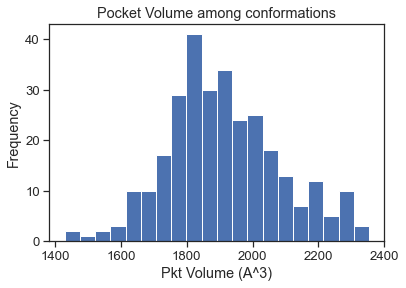

In [19]:
pocket_vol_file = './POVME3_results/Pocket_alignment/res_volumes.tabbed.txt'
# Keep only the Volume column from the POVME3 results
df = pd.read_csv(pocket_vol_file, sep='\t', 
                 header  = None, 
                 names   = ['conf_num', 'volume'])[['volume']]
# Add the volumen information to the main dataframe
df_prot['pocket_volume'] = df.volume.values
ax = df_prot.pocket_volume.plot.hist(bins = 20)
ax.set(title  = 'Pocket Volume among conformations', 
       xlabel = 'Pkt Volume (A^3)')
plt.show()

In [20]:
df_prot

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,pocket_volume
1byq,in vivo function of hsp90 is dependent on atp ...,1998-10-28,1,A,1.50,1.0,29.098,2,"[10, 509]","[[1, 10], [224, 732]]",2,"[ADP, MG]",ADP,412.082022,2156.0
1osf,crystal structure and molecular modeling of 17...,2003-05-27,1,A,1.75,1.0,29.372,2,"[8, 509]","[[1, 8], [224, 732]]",3,"[KOS, ACY, MPD]",KOS,568.364400,2125.0
1uy6,structure-activity relationships in purine-bas...,2004-07-01,1,A,1.90,1.0,28.279,2,"[16, 509]","[[1, 16], [224, 732]]",1,[PU3],PU3,346.235000,1982.0
1uy7,structure-activity relationships in purine-bas...,2004-07-01,1,A,1.90,1.0,28.415,2,"[15, 509]","[[1, 15], [224, 732]]",1,[PU4],PU4,290.214800,1872.0
1uy8,structure-activity relationships in purine-bas...,2004-07-01,1,A,1.98,1.0,28.279,2,"[16, 509]","[[1, 16], [224, 732]]",1,[PU5],PU5,290.214800,1891.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6u99,ligand conformational bias drives enantioselec...,2020-02-19,1,A,1.60,1.0,28.415,2,"[15, 509]","[[1, 15], [224, 732]]",1,[Q2J],,NaN,2053.0
6u9a,ligand conformational bias drives enantioselec...,2020-02-19,1,A,1.65,1.0,28.415,2,"[15, 509]","[[1, 15], [224, 732]]",1,[Q2A],,NaN,1982.0
6u9b,ligand conformational bias drives enantioselec...,2020-02-19,1,A,1.75,1.0,28.415,2,"[15, 509]","[[1, 15], [224, 732]]",1,[Q2A],,NaN,1914.0
7lsz,selective inhibition of the hsp90 alpha isoform.,2021-03-03,1,A,1.70,1.0,28.415,2,"[15, 509]","[[1, 15], [224, 732]]",1,[ONG],,NaN,2017.0


## Classical Multidimensional Scaling

In [19]:
%run ../../helper_modules/MDS.py

In [20]:
pkt_str_mask

':150,54,135,47,137,102,107,139,106,51,132,96,49,53,138,50,48,95,112,91,133,184,58,134,55,98,56,186,131,185,52,93,97,152,183,136&(@CA)'

#### cMDS: Using RMSD as distance metric


In [21]:
# Compute the distance matrices
pair_rmsd_sec = pyt.pairwise_rmsd(traj = crys_traj,
                                  mask = sec_str_mask, 
                                  metric ='rms')

pair_rmsd_pkt = pyt.pairwise_rmsd(traj = crys_traj,
                                  mask = pkt_str_mask, 
                                  metric ='rms')

In [22]:
# Compute cMDS
mds_sec = cMDS(pair_rmsd_sec)[0]
mds_pkt = cMDS(pair_rmsd_pkt)[0]

In [23]:

mds_sec.shape
mds_sec[:1].shape

(1, 296)

#### Visualize the projections

In [24]:
def plot_subspace(x, y, title = '', **kwargs):
    '''A simple scatterplot function'''
    fig, ax = plt.subplots(figsize = (6, 6))
    sns.scatterplot(x = x, y = y, alpha = 0.6,
                    linewidth = 0, color = '#02A298',
                    **kwargs
                   )
    ax.set_title(title)
    ax.set(xlabel = 'Dim. 1', ylabel = 'Dim. 2')
    ax.axvline(0, ls = ':', color = 'gray')
    ax.axhline(0, ls = ':', color = 'gray')
    ax.grid()
    plt.show()

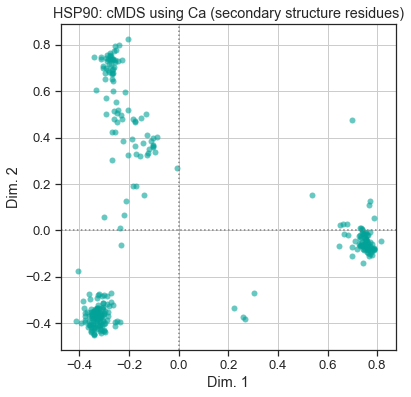

In [25]:
# Visualize the projection
x, y = mds_sec[:2]
plot_subspace(x, y, 
    title = f'{prot_name.upper()}: cMDS using Ca (secondary structure residues)')

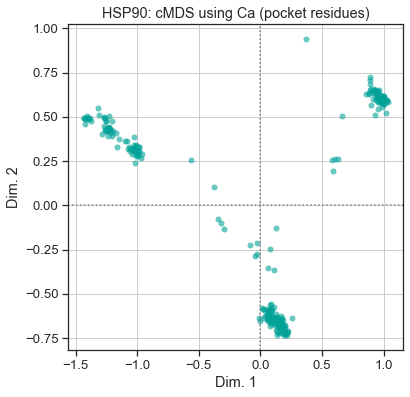

In [26]:
# Visualize the projection
x, y = mds_pkt[:2]
plot_subspace(x, y, 
    title = f'{prot_name.upper()}: cMDS using Ca (pocket residues)')

#### cMDS: Using pocket shape similarity

In [27]:
# Load POVME3 results
path_povme_results = './POVME3_results/Pocket_alignment/'
vol_tan_mtx = pd.read_csv(f'{path_povme_results}/POVME_Tanimoto_matrix.csv', header=None)

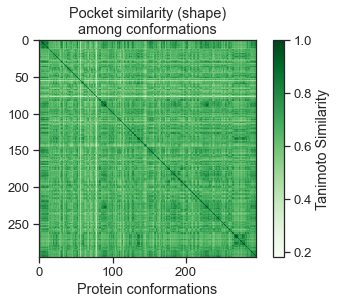

In [28]:
# The following figure shows the 
# Tanimoto Similarity among pockets saphes
fig, ax = plt.subplots()
plt.imshow(vol_tan_mtx, cmap = 'Greens')
ax.set(xlabel = 'Protein conformations',
       title  = "Pocket similarity (shape)\n" + \
                "among conformations"
      )
plt.colorbar(label = 'Tanimoto Similarity')
plt.show()

In [29]:
# cMDS using Tanimoto
# Compute a dissimilarity matrix
dism_mtx = 1 - vol_tan_mtx
mds_vol_pkt = cMDS(dism_mtx)[0]

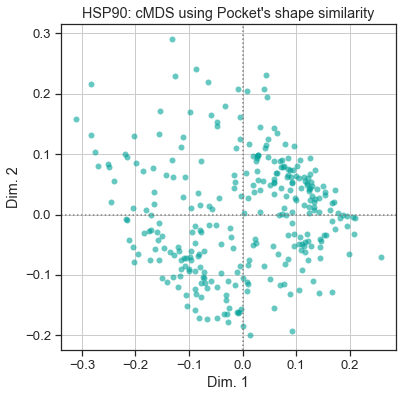

In [30]:
# Visualize the projection
x, y = mds_vol_pkt[:2]
plot_subspace(x, y, 
    title = f"{prot_name.upper()}: cMDS using Pocket's shape similarity")

## Save the projections

In [31]:
df_dims = pd.DataFrame([mds_sec[0], mds_sec[1],
                        mds_pkt[0], mds_pkt[1],
                        mds_vol_pkt[0], mds_vol_pkt[1]]).T

# Set names
colnames = ['mds_sec_x', 'mds_sec_y',
            'mds_pkt_x', 'mds_pkt_y',
            'mds_vol_pkt_x', 'mds_vol_pkt_y',
           ]

# Set the names
df_dims.columns = colnames
# Set index
df_dims.index = df_prot.index
# Save to file
df_dims.to_pickle('./df_PROTEINS_DIMS_reduced_TABLE.obj')

Fnished!